## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns


/var/folders/mh/7y8l5v9554l4khdmmkyyg8400000gn/T/ipykernel_18060/1869193069.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Hypothesis

**Points of focus**

1. We would like to identify segments of customers that are more prone to churn. This will help design an algorithm that performs well for such segments specifically.

2. We would also like to identify most common causes of churn - is it poor app experience, or low speed of internet that is causing the customers to churn.


## Load the data

In [2]:
data = pd.read_csv("../data/WA_Fn-UseC_-Telco-Customer-Churn.csv")

## Data cleaning

### Check for NULLs in the columns

1. Although there seem to be no NULLs in any of the columns, but there might be a possibility that some column values are `""` empty strings. We will need to handle such cases.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### Change column to appropriate types

1. One observation is that `TotalCharges` columns is of `object` type. But looking at the values, it makese sense to change this to `float64`.


In [4]:
def convert_total_charges_to_float(data):

    data['TotalCharges'] = data['TotalCharges'].map(lambda x: np.nan if isinstance(x, str) and x.strip() == '' else x)

    before_nan_indices = data[pd.isna(data['TotalCharges'])].index.tolist()

    print('Index Positions with empty spaces before interpolation: ', before_nan_indices)

    # Fill indices with NaN with the last seen non-null value
    # I know that this is not the best way to do this but we will try to
    # improve this later
    
    data["TotalCharges"] = data['TotalCharges'].ffill(inplace=False)

    after_nan_indices = data[pd.isna(data['TotalCharges'])].index.tolist()

    print('Index Positions with empty spaces after interpolation: ', after_nan_indices)

    # Finally, convert all the non-empty string float values to float
    data['TotalCharges'] = data['TotalCharges'].astype(float)

    return data

In [5]:
data = convert_total_charges_to_float(data)

Index Positions with empty spaces before interpolation:  [488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754]
Index Positions with empty spaces after interpolation:  []


### Drop `customerID` column

In [6]:
data = data.drop(columns = ['customerID'], inplace = False)

### Define categorical and numeric features

1. Looking at the column names and their unique values, following columns are numeric types - 

    - `tenure`
    - `MonthlyCharges`
    - `TotalCharges`
    
Other columns are categorical features. We will have to encode these categorical features into numeric categories before feeding them into a ML model.

In [7]:
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_cols = [col for col in data.columns if col not in numeric_cols]

In [8]:
def get_unique_values(df, column_names):
    for col in column_names:
        if col in df.columns:
            print (f"Col {col}: {df[col].unique().tolist()}")
        else:
            print (f"Col {col}: Column not found in dataframe.")

In [9]:
get_unique_values(data, categorical_cols)

Col gender: ['Female', 'Male']
Col SeniorCitizen: [0, 1]
Col Partner: ['Yes', 'No']
Col Dependents: ['No', 'Yes']
Col PhoneService: ['No', 'Yes']
Col MultipleLines: ['No phone service', 'No', 'Yes']
Col InternetService: ['DSL', 'Fiber optic', 'No']
Col OnlineSecurity: ['No', 'Yes', 'No internet service']
Col OnlineBackup: ['Yes', 'No', 'No internet service']
Col DeviceProtection: ['No', 'Yes', 'No internet service']
Col TechSupport: ['No', 'Yes', 'No internet service']
Col StreamingTV: ['No', 'Yes', 'No internet service']
Col StreamingMovies: ['No', 'Yes', 'No internet service']
Col Contract: ['Month-to-month', 'One year', 'Two year']
Col PaperlessBilling: ['Yes', 'No']
Col PaymentMethod: ['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)']
Col Churn: ['No', 'Yes']


### Encode the categorical features

In [10]:

def encode_categorical_feats(df, categorical_cols):

    # This will store the LabelEncoder instances for each column
    # We can use these later to perform an inverse transform (encoded labels -> original labels)
    encoder_dict = {}
    
    for col in categorical_cols:
        if col in df.columns:
            le = LabelEncoder()

            df[col] = le.fit_transform(df[col])

            encoder_dict[col] = le

        else:
            print (f"Column {col} not found in Dataframe")
    
    return df, encoder_dict



data_copy = data.copy(deep=True)

In [11]:
# We will create a copy and keep it safe in case we want the original labels
# All subsequent operations will be performed on dataframe `data`
data_copy = data.copy(deep=True)

data, label_encoder_dicts = encode_categorical_feats(data, categorical_cols=categorical_cols)

#### Original dataframe

In [12]:
data_copy.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#### Dataframe with encoded labels

In [13]:
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   int64  
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   int64  
 3   Dependents        7043 non-null   int64  
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   int64  
 6   MultipleLines     7043 non-null   int64  
 7   InternetService   7043 non-null   int64  
 8   OnlineSecurity    7043 non-null   int64  
 9   OnlineBackup      7043 non-null   int64  
 10  DeviceProtection  7043 non-null   int64  
 11  TechSupport       7043 non-null   int64  
 12  StreamingTV       7043 non-null   int64  
 13  StreamingMovies   7043 non-null   int64  
 14  Contract          7043 non-null   int64  
 15  PaperlessBilling  7043 non-null   int64  
 16  PaymentMethod     7043 non-null   int64  


## Feature reduction/selection

- calculate correlation matrices, chi-squared test and anova test to find features that are least impacting the target variable `label`.
- look at the plots in this EDA notebook and then select some important features based on intuition.


### Find features that are most correlated to the target `Churn`

#### Correlation matrix

1. `MulipleLines`, `PhoneService`, `gender`, `StreamingTV`, `StreamingMovies` and `InternetService` have relatively low magnitudes of correlation in the range of `(-0.1, 0.1)`.

2. Other features either have a high +ve or -ve correlation with churn.

Text(0.5, 1.0, 'Correlation w.r.t churn')

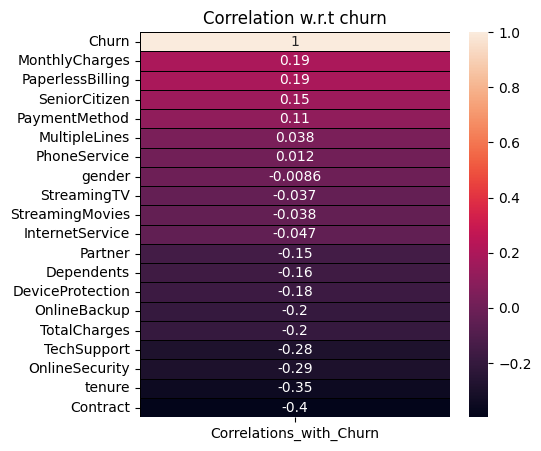

In [15]:
corr_matrix = data.corrwith(data['Churn']).sort_values(ascending=False).to_frame()
corr_matrix.columns = ['Correlations_with_Churn']

plt.subplots(figsize=(5, 5))
sns.heatmap(corr_matrix, annot = True, linewidths = 0.4,linecolor = 'black')
plt.title('Correlation w.r.t churn')


#### Chi-Squared Test

1. We observe the same features (`MulipleLines`, `PhoneService`, `gender`, `StreamingTV`, `StreamingMovies` and `InternetService`) that had low correlation values with 'Churn', also have low chi-squared test values. This strengthens our previous observation.

2. So it makes sense to remove these features. 

Text(0.5, 1.0, 'Chi squared test results')

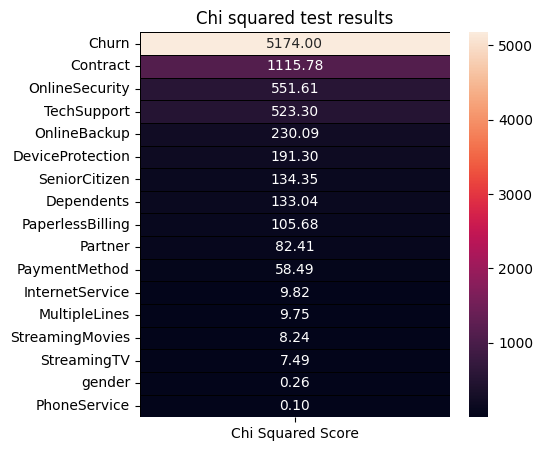

In [16]:
from sklearn.feature_selection import SelectKBest, chi2


features = data.loc[:, categorical_cols]
target = data.loc[:, 'Churn']

best_features = SelectKBest(score_func=chi2, k='all')
fit = best_features.fit(features, target)

feature_chi_scores = pd.DataFrame(data = fit.scores_, index = list(features.columns),columns = ['Chi Squared Score'])

plt.subplots(figsize=(5, 5))
sns.heatmap(feature_chi_scores.sort_values(ascending=False, by='Chi Squared Score'),
            annot = True,
            linewidths=0.4,
            linecolor='black',
            fmt='.2f')

plt.title('Chi squared test results')

#### ANOVA test for selecting numeric features

1. All 3 numeric features (`tenure`, `TotalCharges`, `MonthlyCharges`) are important as they have high ANOVA score values wrt `Churn`.

2. So we will not drop any of them.

Text(0.5, 1.0, 'Anova test results')

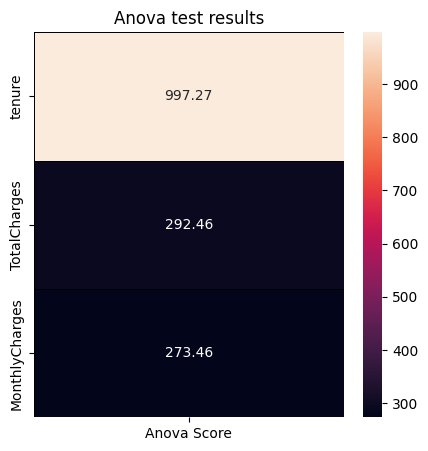

In [17]:
from sklearn.feature_selection import SelectKBest, f_classif


features = data.loc[:, numeric_cols]
target = data.loc[:, 'Churn']

best_features = SelectKBest(score_func=f_classif, k='all')
fit = best_features.fit(features, target)

feature_chi_scores = pd.DataFrame(data = fit.scores_, index = list(features.columns),columns = ['Anova Score'])

plt.subplots(figsize=(5, 5))
sns.heatmap(feature_chi_scores.sort_values(ascending=False, by='Anova Score'),
            annot = True,
            linewidths=0.4,
            linecolor='black',
            fmt='.2f')

plt.title('Anova test results')

### Drop categorical feats with low correlation with `Churn`

In [18]:
data = data.drop(columns=['PhoneService', 'gender','StreamingTV','StreamingMovies','MultipleLines','InternetService'], inplace=False)

data.head()

,SeniorCitizen,Partner,Dependents,tenure,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,1,0,1,0,2,0,0,0,1,2,29.85,29.85,0
1,0,0,0,34,2,0,2,0,1,0,3,56.95,1889.50,0
2,0,0,0,2,2,2,0,0,0,1,3,53.85,108.15,1
3,0,0,0,45,2,0,2,2,1,0,0,42.30,1840.75,0
4,0,0,0,2,0,0,0,0,0,1,2,70.70,151.65,1


### Finding redundant features

Redundant features that are highly correlated with each other. We will then only keep one of them.

In [19]:
from scipy.stats import chi2_contingency

def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return np.sqrt(stat/(obs*mini))


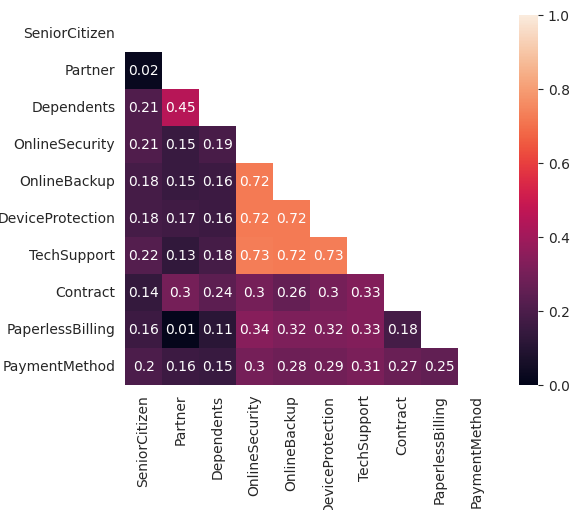

In [20]:
relevant_cat_cols = [col for col in data.columns if col not in ['Churn', 'MonthlyCharges', 'TotalCharges', 'tenure']]
cat_data = data.loc[:, relevant_cat_cols]
rows= []

for var1 in cat_data:
  col = []
  for var2 in cat_data :
    cramers = cramers_V(cat_data[var1], cat_data[var2]) # Cramer's V test
    col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)
  
cramers_results = np.array(rows)
cramers_df = pd.DataFrame(cramers_results, columns = cat_data.columns, index =cat_data.columns)


mask = np.zeros_like(cramers_df, dtype=bool)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
  ax = sns.heatmap(cramers_df, annot=True, mask=mask,vmin=0., vmax=1, square=True)

plt.show()

#### Should we remove categorical feats with high Cramers V value (close to 1)?

1. From the above heatmap, `OnlineBackup`, `DeviceProtection`, and `TechSupport` have relatively high Cramers V scores. It seems tempting to remove them.

2. But before doing that, let's see do they have any impact on the churn. For this, let's plot a histogram, showing distribution of churn vs not-churn customers for different values of these categorical feats.

3. We can clearly see from the histogram below that absence of any of these services leads to high customer churn. This means that these are good predictors of customer churn and it would not be wise to remove them.

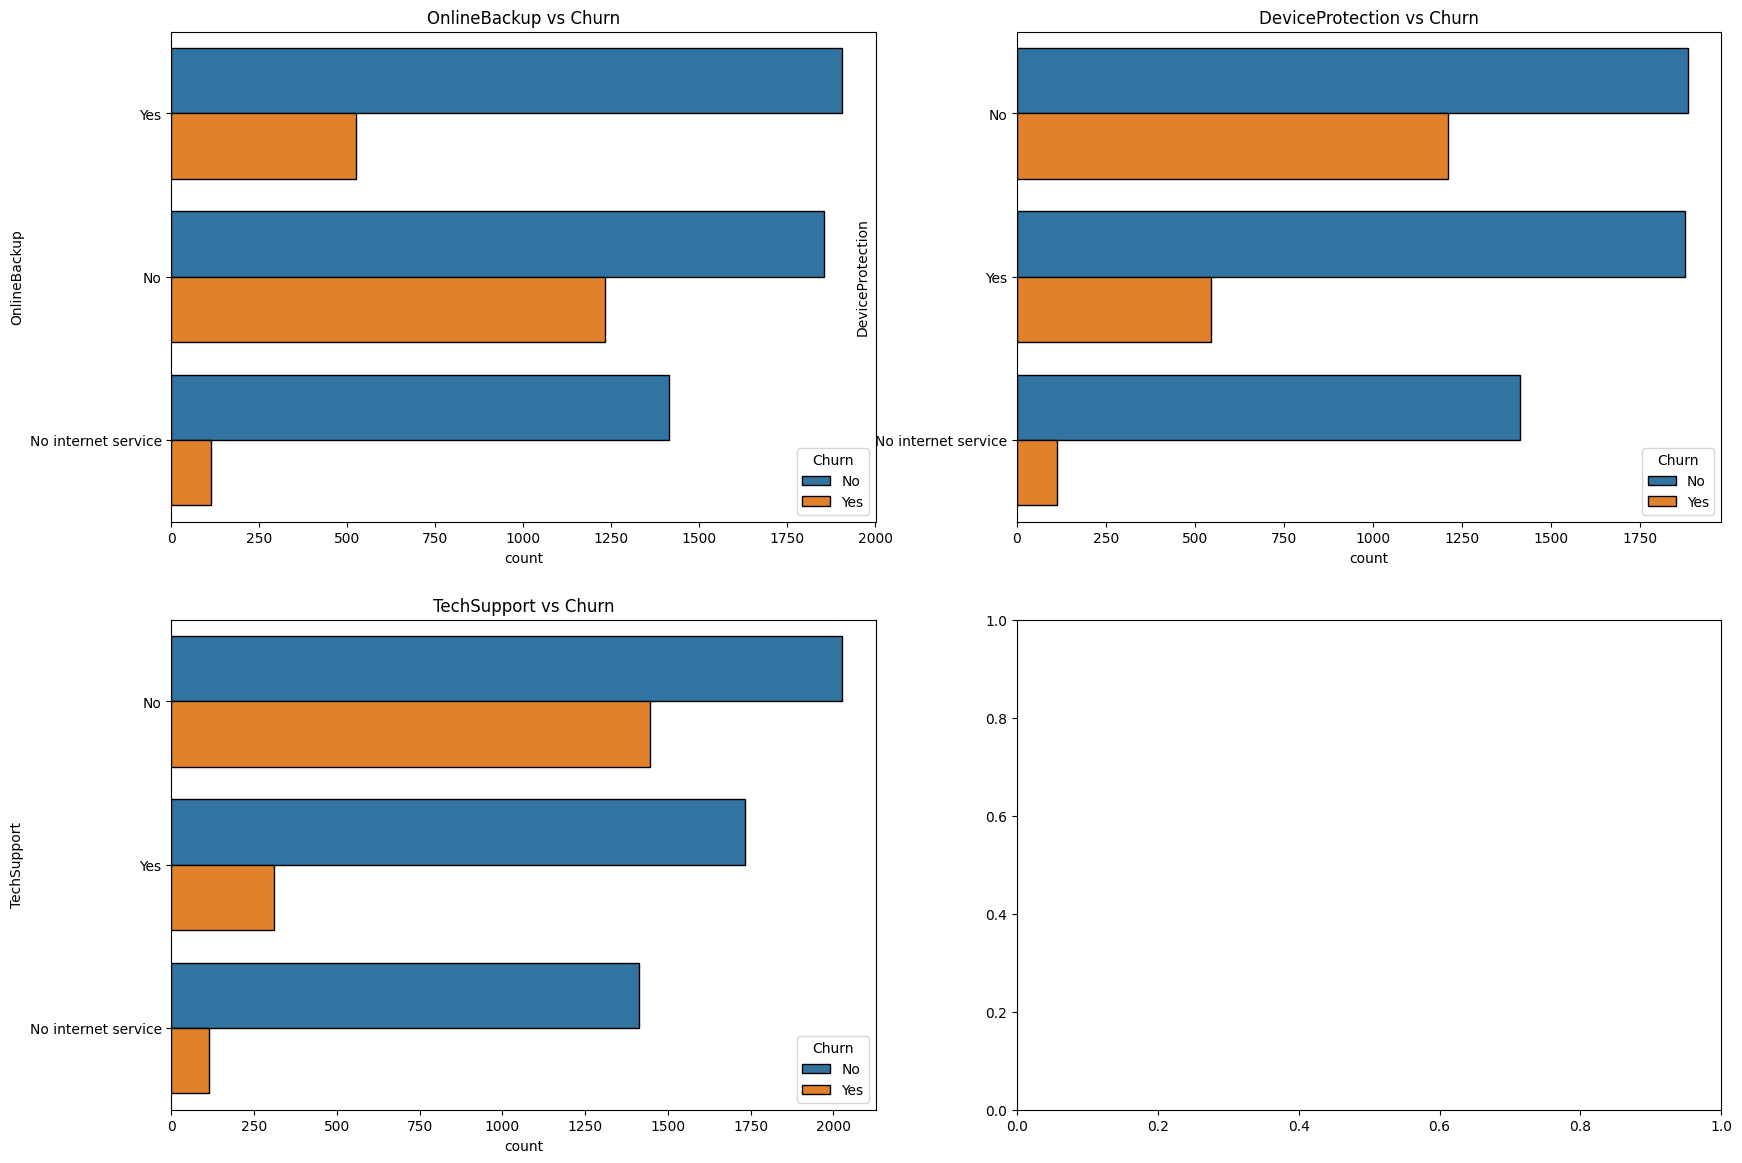

In [21]:
feats = ['OnlineBackup', 'DeviceProtection', 'TechSupport']
fig = plt.subplots(nrows = 2,ncols = 2,figsize = (20,14))
for i in range(len(feats)):
    plt.subplot(2,2,i+1)
    ax = sns.countplot(data = data_copy, y=feats[i], hue = "Churn", edgecolor = 'black')
    title = feats[i] + ' vs Churn'
    plt.title(title)

## Scale numeric features


In [22]:
# def plot_column_distributions(df, col_names):

#     # Setup the matplotlib figure and axes
#     fig, axs = plt.subplots(3, 1, figsize=(7, 10))
    
#     for i, col_name in enumerate(col_names):
#         # Plot each column's distribution
#         sns.histplot(df[col_name], kde=True, ax=axs[i])
#         axs[i].set_title(f'Distribution of {col_name}')
    
#     # Adjust layout for better readability
#     plt.tight_layout()
    
#     # Show the plot
#     plt.show()


# plot_column_distributions(data, ['tenure', 'MonthlyCharges', 'TotalCharges'])

In [23]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

data['tenure'] = scaler.fit_transform(data[['tenure']])
data['MonthlyCharges'] = scaler.fit_transform(data[['MonthlyCharges']])
data['TotalCharges'] = scaler.fit_transform(data[['TotalCharges']])

data.head()

,SeniorCitizen,Partner,Dependents,tenure,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,1,0,0.013889,0,2,0,0,0,1,2,0.115423,0.001275,0
1,0,0,0,0.472222,2,0,2,0,1,0,3,0.385075,0.215867,0
2,0,0,0,0.027778,2,2,0,0,0,1,3,0.354229,0.010310,1
3,0,0,0,0.625000,2,0,2,2,1,0,0,0.239303,0.210241,0
4,0,0,0,0.027778,0,0,0,0,0,1,2,0.521891,0.015330,1


## Data balancing using SMOTE

### Target is imbalanced

Positive label (=1) samples are roughly 3 times lesses than negative label (=0) samples. This will make a ML model bias towards the negative label.

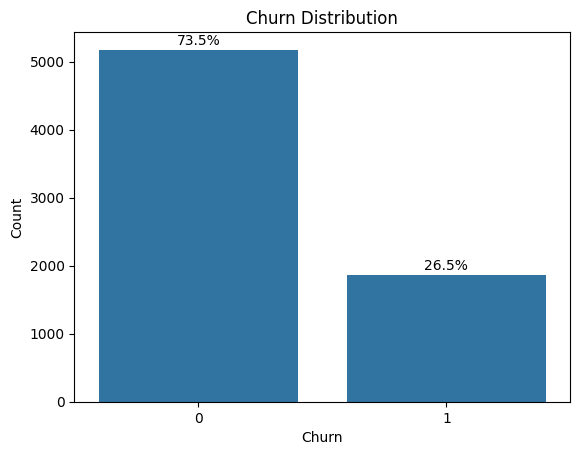

In [27]:
churn_counts = data['Churn'].value_counts()
churn_percentages = 100 * churn_counts / churn_counts.sum()


ax = sns.countplot(x='Churn', data=data)
plt.title('Churn Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')


# Annotate bars with percentage
for i, p in enumerate(ax.patches):
    # Get percentage for this category
    percentage = '{:.1f}%'.format(churn_percentages[i])
    # Position the text above the bar
    x = p.get_x() + p.get_width() / 2
    y = p.get_y() + p.get_height() + 0.01 * churn_counts.sum()  # Adjusted to display above the bar
    ax.annotate(percentage, (x, y), ha='center')

plt.show()

### Applying oversampling of the minority class (churn = 1)


In [35]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split


train_feats = data.drop(columns=['Churn'])
target_vals = data['Churn']

# It's important to separate test set before applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(train_feats, target_vals, test_size=0.2, random_state=42)

print (f"X_train: {X_train.shape}\t y_train: {y_train.shape}")
print (f"X_test: {X_test.shape}\t y_test: {y_test.shape}")

# Initialize oversampler
over_sampler = SMOTE(sampling_strategy=1, random_state=42)

# Apply SMOTE on training data only


print (f"Before SMOTE\n", y_train.value_counts())

X_train_smote, y_train_smote = over_sampler.fit_resample(X_train, y_train)


print (f"After SMOTE\n", y_train_smote.value_counts())


X_train: (5634, 13)	 y_train: (5634,)
X_test: (1409, 13)	 y_test: (1409,)
Before SMOTE
 Churn
0    4138
1    1496
Name: count, dtype: int64
After SMOTE
 Churn
0    4138
1    4138
Name: count, dtype: int64


## Model building

### Model utilites

In [44]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

def train_model(classifier, x_train, y_train):
    classifier.fit(x_train,y_train)
    cv = RepeatedStratifiedKFold(n_splits = 10,n_repeats = 3,random_state = 1)
    print("Cross Validation Score : ",'{0:.2%}'.format(cross_val_score(classifier,x_train,y_train,cv = cv,scoring = 'f1').mean()))

    return classifier


def eval_model(classifier, x_test, y_test):
    # Confusion matrix
    cm = confusion_matrix(y_test,classifier.predict(x_test))
    names = ['True Neg','False Pos','False Neg','True Pos']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm,annot = labels,cmap = 'Blues',fmt ='')
    
    # Classification Report
    print(classification_report(y_test,classifier.predict(x_test)))


### Random forest classifier

Cross Validation Score :  77.70%
              precision    recall  f1-score   support

           0       0.93      0.70      0.80      1036
           1       0.51      0.85      0.63       373

    accuracy                           0.74      1409
   macro avg       0.72      0.78      0.72      1409
weighted avg       0.82      0.74      0.76      1409



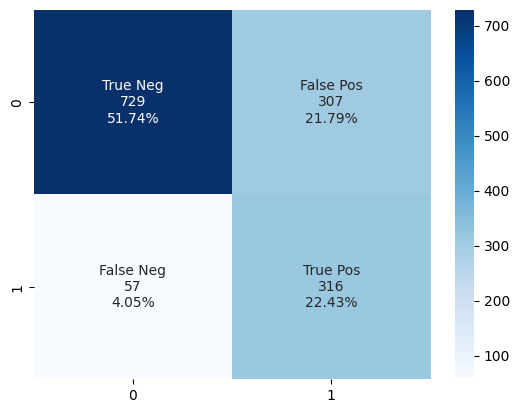

In [58]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(max_depth=4, random_state=42)

classifier = train_model(classifier=classifier, x_train=X_train_smote, y_train=y_train_smote)

eval_model(classifier=classifier, x_test=X_test, y_test=y_test)

              precision    recall  f1-score   support

           0       0.87      0.84      0.86      1036
           1       0.60      0.66      0.63       373

    accuracy                           0.79      1409
   macro avg       0.74      0.75      0.74      1409
weighted avg       0.80      0.79      0.80      1409



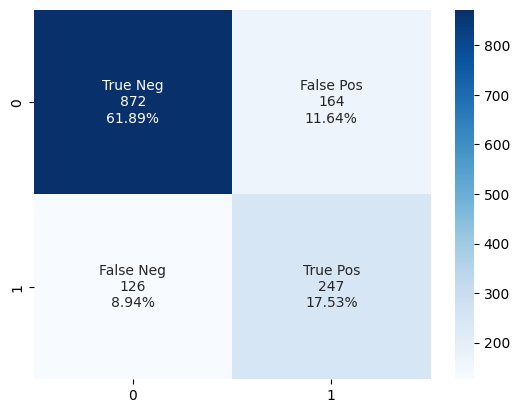

In [59]:
from sklearn.metrics import precision_recall_curve

proba_for_churn = classifier.predict_proba(X_test)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, probas_pred=proba_for_churn)

best_threshold = thresholds[np.argmax(precisions >= 0.60)]

y_predictions = (proba_for_churn >= best_threshold).astype(int)


cm = confusion_matrix(y_test, y_predictions)
names = ['True Neg','False Pos','False Neg','True Pos']
counts = [value for value in cm.flatten()]
percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm,annot = labels,cmap = 'Blues',fmt ='')

# Classification Report
print(classification_report(y_test, y_predictions))

### XGBClassifier

Cross Validation Score :  80.78%
              precision    recall  f1-score   support

           0       0.89      0.77      0.83      1036
           1       0.54      0.74      0.62       373

    accuracy                           0.76      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.76      0.77      1409



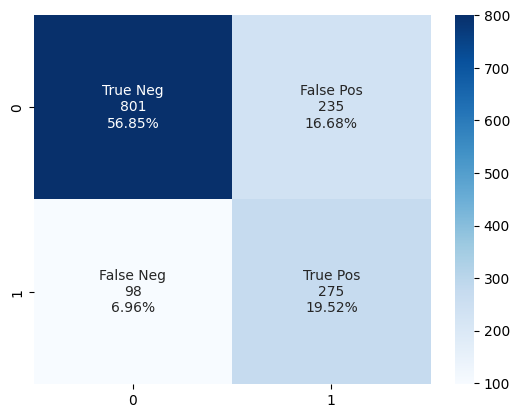

In [53]:
from xgboost import XGBClassifier

classifier_xgb = XGBClassifier(learning_rate= 0.01,max_depth = 8, n_estimators = 1000)


classifier_xgb = train_model(classifier=classifier_xgb, x_train=X_train_smote, y_train=y_train_smote)

eval_model(classifier=classifier_xgb, x_test=X_test, y_test=y_test)

## Hyperparameter tuning

## Apply feature selection

Use this [https://www.kaggle.com/code/arunmohan003/feature-selection-tutorial]

## Summary of EDA

## TODO

1. Outlier detection and removal